In [28]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
import spacy
from sumy.summarizers.text_rank import TextRankSummarizer
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tarfile
import io
import json
from rouge import Rouge
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

In [2]:
def summarize_text(text, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    summarizers = {
        "Edmundson": EdmundsonSummarizer(),
        "LSA": LsaSummarizer(),
        "KL": KLSummarizer(),
        "LexRank": LexRankSummarizer()
    }
    
    results = {}
    
    for name, summarizer in summarizers.items():
        if name == "Edmundson":
            summarizer.bonus_words = ["NLP", "language", "algorithms", "AI", "natural"]
            summarizer.stigma_words = ["is", "the", "a", "of", "and", "to", "in"]
            summarizer.null_words = ["and", "or", "but", "if", "then", "with", "so", "on"]
        
        summary = summarizer(parser.document, num_sentences)
        results[name] = "\n".join(str(sentence) for sentence in summary)
    
    return results

# Function to summarize from a file
def summarize_from_file(file_path, num_sentences=3):
    with open(file_path, 'r') as file:
        text = file.read()
    return summarize_text(text, num_sentences)

def summarize_from_url(url, num_sentences=3):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    text = soup.get_text()
    return summarize_text(text, num_sentences)

# Example usage
document = """
Natural Language Processing (NLP) is a field of artificial intelligence that focuses on the interaction between computers and humans using natural language. The goal is to enable machines to understand, interpret, and generate human language in a way that is meaningful and useful. NLP combines computational linguistics, rule-based modeling of human language, and machine learning to build models that can process large amounts of natural language data. The primary tasks in NLP range from basic text preprocessing to more complex tasks like language generation and understanding. Text preprocessing involves cleaning and preparing the text for analysis, breaking it into manageable units through tokenization, stemming, lemmatization, stopword removal, and part-of-speech tagging. Once text is preprocessed, syntactic and semantic analysis techniques help machines understand the structure and meaning of sentences, including parsing, dependency parsing, named entity recognition, and word sense disambiguation. Language modeling plays a key role in predicting the next word or phrase in a sentence based on the previous words, and this underpins many NLP applications like text generation, speech recognition, and machine translation. Sentiment analysis identifies the sentiment expressed in a text and is widely used in social media monitoring and customer feedback systems. Automatic text summarization reduces large pieces of text to shorter versions while retaining key information, which can be done through extractive summarization (selecting important sentences or phrases) or abstractive summarization (generating a summary in its own words). Question answering systems are designed to answer human questions based on contextual understanding of text, and they are seen in applications such as search engines and virtual assistants. NLP techniques and models have evolved significantly with the rise of deep learning. Bag of Words is a basic technique for converting text into numerical data, while TF-IDF builds on this by weighting words based on their importance in the text corpus. Word embeddings like Word2Vec, GloVe, and FastText create dense vector representations of words that capture semantic relationships between them. However, the real revolution in NLP came with the introduction of Transformer models. Transformers, like BERT and GPT, are neural networks that excel at understanding complex language patterns and are used in tasks such as text generation, sentiment analysis, and machine translation. Recurrent neural networks (RNNs) and Long Short-Term Memory (LSTM) models were previously dominant for sequence-based NLP tasks but have been largely replaced by Transformer architectures due to their superior ability to capture long-range dependencies in text. NLP is used in a wide variety of applications, from search engines and chatbots to healthcare, legal document analysis, and financial services. Despite these advances, NLP faces challenges such as the inherent ambiguity of human language, the diversity of languages and dialects, and the need for better understanding of context in conversations. Ethical concerns also arise, as NLP systems may perpetuate biases present in the training data. Nevertheless, NLP is transforming industries by enabling machines to interact with humans in more intuitive and effective ways.
"""

summaries = summarize_text(document)

for name, summary in summaries.items():
    print(f"\n{name} Summary:")
    print(summary)

# Example usage for file and URL
file_path = "/home/t/Desktop/koulu/nltk/proj/test.in"
file_summaries = summarize_from_file(file_path)

url = "https://en.wikipedia.org/wiki/Natural_language_processing"
url_summaries = summarize_from_url(url)

print("\nFile Summaries:")
for name, summary in file_summaries.items():
    print(f"\n{name} Summary:")
    print(summary)

print("\nURL Summaries:")
for name, summary in url_summaries.items():
    print(f"\n{name} Summary:")
    print(summary)


Edmundson Summary:
Natural Language Processing (NLP) is a field of artificial intelligence that focuses on the interaction between computers and humans using natural language.
NLP combines computational linguistics, rule-based modeling of human language, and machine learning to build models that can process large amounts of natural language data.
Ethical concerns also arise, as NLP systems may perpetuate biases present in the training data.

LSA Summary:
Word embeddings like Word2Vec, GloVe, and FastText create dense vector representations of words that capture semantic relationships between them.
Ethical concerns also arise, as NLP systems may perpetuate biases present in the training data.
Nevertheless, NLP is transforming industries by enabling machines to interact with humans in more intuitive and effective ways.

KL Summary:
The goal is to enable machines to understand, interpret, and generate human language in a way that is meaningful and useful.
Language modeling plays a key ro

In [4]:
# Initialize ROUGE
rouge = Rouge()

# Initialize summarizers
edmundson = EdmundsonSummarizer()
edmundson.bonus_words = ["important", "significant", "key", "central", "crucial"]
edmundson.stigma_words = ["trivial", "minor", "unimportant", "insignificant"]
edmundson.null_words = ["the", "a", "an", "in", "on", "at", "for", "of", "with"]

summarizers = {
    "Edmundson": edmundson,
    "LSA": LsaSummarizer(),
    "KL": KLSummarizer(),
    "LexRank": LexRankSummarizer()
}

def generate_summary(text, summarizer, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

def evaluate_summarizer(summarizer, data):
    rouge_1_scores = []
    rouge_2_scores = []
    rouge_l_scores = []
    
    for _, row in data.iterrows():
        full_text = row['summary']
        reference_summary = row['title'] + ". " + " ".join(full_text.split()[:30])  # Use title and first 30 words as reference
        generated_summary = generate_summary(full_text, summarizer)
        
        scores = rouge.get_scores(generated_summary, reference_summary)[0]
        rouge_1_scores.append(scores['rouge-1']['f'])
        rouge_2_scores.append(scores['rouge-2']['f'])
        rouge_l_scores.append(scores['rouge-l']['f'])
    
    return np.mean(rouge_1_scores), np.mean(rouge_2_scores), np.mean(rouge_l_scores)

# Load the Wikipedia Summary Dataset
def load_wiki_summary_data(file_path, num_samples=100):
    with tarfile.open(file_path, "r:gz") as tar:
        txt_file = [f for f in tar.getmembers() if f.name.endswith('.txt')][0]
        with tar.extractfile(txt_file) as f:
            content = io.TextIOWrapper(f, encoding='utf-8')
            data = []
            for i, line in enumerate(content):
                if i >= num_samples:
                    break
                title, summary = line.strip().split('|||')
                data.append({'title': title.strip(), 'summary': summary.strip()})
    return pd.DataFrame(data)
import spacy
from sumy.summarizers.text_rank import TextRankSummarizer
data = load_wiki_summary_data('raw.tar.gz', num_samples=100)
print(f"Loaded {len(data)} samples from the dataset.")

# Evaluate each summarizer
results = {}
for name, summarizer in summarizers.items():
    print(f"Evaluating {name} summarizer...")
    rouge_1, rouge_2, rouge_l = evaluate_summarizer(summarizer, data)
    results[name] = {'ROUGE-1': rouge_1, 'ROUGE-2': rouge_2, 'ROUGE-L': rouge_l}

# Print results
for name, scores in results.items():
    print(f"{name} Summarizer:")
    print(f"  ROUGE-1: {scores['ROUGE-1']:.4f}")
    print(f"  ROUGE-2: {scores['ROUGE-2']:.4f}")
    print(f"  ROUGE-L: {scores['ROUGE-L']:.4f}")
    print()

# Analysis and comments
print("Analysis:")
print("1. Performance Comparison:")
best_rouge1 = max(results, key=lambda x: results[x]['ROUGE-1'])
best_rouge2 = max(results, key=lambda x: results[x]['ROUGE-2'])
best_rougel = max(results, key=lambda x: results[x]['ROUGE-L'])
print(f"   - Best ROUGE-1 performance: {best_rouge1}")
print(f"   - Best ROUGE-2 performance: {best_rouge2}")
print(f"   - Best ROUGE-L performance: {best_rougel}")


Loaded 100 samples from the dataset.
Evaluating Edmundson summarizer...
Evaluating LSA summarizer...
Evaluating KL summarizer...
Evaluating LexRank summarizer...
Edmundson Summarizer:
  ROUGE-1: 0.6595
  ROUGE-2: 0.6000
  ROUGE-L: 0.6587

LSA Summarizer:
  ROUGE-1: 0.4125
  ROUGE-2: 0.3041
  ROUGE-L: 0.3991

KL Summarizer:
  ROUGE-1: 0.4443
  ROUGE-2: 0.3397
  ROUGE-L: 0.4361

LexRank Summarizer:
  ROUGE-1: 0.5527
  ROUGE-2: 0.4658
  ROUGE-L: 0.5455

Analysis:
1. Performance Comparison:
   - Best ROUGE-1 performance: Edmundson
   - Best ROUGE-2 performance: Edmundson
   - Best ROUGE-L performance: Edmundson


In [5]:
from openai import OpenAI
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from rouge import Rouge
import numpy as np

# Initialize the OpenAI client
client = OpenAI(api_key='your-api-key-here')

# Initialize ROUGE
rouge = Rouge()

# Initialize summarizers
edmundson = EdmundsonSummarizer()
edmundson.bonus_words = ["NLP", "language", "algorithms", "AI", "natural"]
edmundson.stigma_words = ["is", "the", "a", "of", "and", "to", "in"]
edmundson.null_words = ["and", "or", "but", "if", "then", "with", "so", "on"]

summarizers = {
    "Edmundson": edmundson,
    "LSA": LsaSummarizer(),
    "KL": KLSummarizer(),
    "LexRank": LexRankSummarizer()
}

def generate_gpt_summary(text):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant that summarizes text."},
            {"role": "user", "content": f"Summarize the following text in a few sentences: {text}"}
        ]
    )
    return response.choices[0].message.content.strip()

def generate_summary(text, summarizer, num_sentences=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

def evaluate_summarizer(summarizer, text, gpt_summaries):
    rouge_2_scores = []
    rouge_l_scores = []
    
    generated_summary = generate_summary(text, summarizer)
    
    for gpt_summary in gpt_summaries:
        scores = rouge.get_scores(generated_summary, gpt_summary)[0]
        rouge_2_scores.append(scores['rouge-2']['f'])
        rouge_l_scores.append(scores['rouge-l']['f'])
    
    return np.mean(rouge_2_scores), np.mean(rouge_l_scores)

# Your document
document = """
Natural Language Processing (NLP) is a field of artificial intelligence that focuses on the interaction between computers and humans using natural language. The goal is to enable machines to understand, interpret, and generate human language in a way that is meaningful and useful. NLP combines computational linguistics, rule-based modeling of human language, and machine learning to build models that can process large amounts of natural language data. The primary tasks in NLP range from basic text preprocessing to more complex tasks like language generation and understanding. Text preprocessing involves cleaning and preparing the text for analysis, breaking it into manageable units through tokenization, stemming, lemmatization, stopword removal, and part-of-speech tagging. Once text is preprocessed, syntactic and semantic analysis techniques help machines understand the structure and meaning of sentences, including parsing, dependency parsing, named entity recognition, and word sense disambiguation. Language modeling plays a key role in predicting the next word or phrase in a sentence based on the previous words, and this underpins many NLP applications like text generation, speech recognition, and machine translation.
"""

# Use the GPT summaries you've already generated
gpt_summaries = [
    "Natural Language Processing (NLP) is a branch of artificial intelligence focusing on computer-human interaction through language. It aims to help machines understand, interpret, and produce human language effectively. NLP involves tasks such as text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, text summarization, and question answering. Evolution in NLP includes the shift from traditional methods like Bag of Words and TF-IDF to advanced techniques such as Word embeddings and Transformer models like BERT and GPT. NLP has diverse applications ranging from search engines to healthcare and poses challenges like language diversity and biases in training data. Despite these challenges, NLP is revolutionizing industries by enhancing human-machine communication."
    "Natural Language Processing (NLP) is a field of artificial intelligence focused on enabling computers to understand, interpret, and generate human language. It combines computational linguistics and machine learning to process natural language data, from basic preprocessing to complex tasks like language generation and understanding. NLP tasks include text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, text summarization, and question answering systems. Recent developments in deep learning have advanced NLP techniques, with Transformer models like BERT and GPT outperforming traditional methods like RNNs and LSTMs. NLP is widely used across industries, but challenges such as language ambiguity, diversity, and ethical concerns remain.",
    "Natural Language Processing (NLP) is a field of artificial intelligence that aims to enable computers to understand, interpret, and generate human language. NLP involves tasks like text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, automatic text summarization, and question answering systems. Traditional NLP techniques like Bag of Words and TF-IDF have been enhanced by word embeddings and Transformer models like BERT and GPT, which excel at understanding complex language patterns. NLP is utilized in various applications such as search engines, chatbots, healthcare, legal document analysis, and financial services, but faces challenges in dealing with language ambiguity, diversity, context understanding, and ethical biases. Despite these challenges, NLP continues to transform industries by improving human-computer interactions.",
    "Natural Language Processing (NLP) is a field of artificial intelligence focused on enabling machines to understand, interpret, and generate human language effectively. It combines computational linguistics, rule-based modeling, and machine learning to process natural language data. NLP tasks include text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, text summarization, and question answering systems. NLP techniques, such as Bag of Words, TF-IDF, and word embeddings like Word2Vec, have evolved with deep learning and Transformer models like BERT and GPT have revolutionized NLP applications. Despite challenges like language ambiguity and biases in training data, NLP is transforming industries by enhancing human-machine interaction.",
    "Natural Language Processing (NLP) is an area of artificial intelligence that focuses on computers understanding and generating human language. NLP tasks include text preprocessing, syntactic and semantic analysis, language modeling for prediction, sentiment analysis, text summarization, and question answering systems. Techniques like Bag of Words, TF-IDF, word embeddings, and Transformer models like BERT and GPT have evolved to enhance NLP capabilities. Although NLP is widely used in various applications and industries, challenges such as language ambiguity, diversity, context understanding, and ethical concerns related to biases in data remain.",
    "Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on computers' interaction with human language. NLP involves tasks like text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, text summarization, and question answering. Techniques in NLP have evolved from Bag of Words and TF-IDF to word embeddings like Word2Vec and advanced Transformer models like BERT and GPT, which excel at understanding complex language patterns. NLP is used in various applications, but faces challenges such as human language ambiguity, diversity of languages, context understanding, and ethical concerns regarding biases in training data. Despite challenges, NLP is revolutionizing industries by improving human-machine interactions.",
    "Natural Language Processing (NLP) is a field of artificial intelligence that aims to facilitate communication between computers and humans using human language. It involves tasks such as text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, automatic text summarization, question answering systems, and more. NLP techniques have evolved, with Transformer models like BERT and GPT being widely used for tasks such as text generation and sentiment analysis. Despite challenges like language ambiguity and bias issues, NLP is making significant strides in various industries by enhancing human-computer interaction.",
    "Natural Language Processing (NLP) is a field of artificial intelligence focused on enabling computers to understand and generate human language. Techniques like text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, automatic text summarization, and question answering systems are used to process natural language data. Recent advancements in deep learning, particularly Transformer models like BERT and GPT, have revolutionized NLP by improving language understanding and performance in various tasks. Despite challenges such as language diversity and ethical concerns around bias, NLP is reshaping industries by enhancing human-machine interaction.",
    "Natural Language Processing (NLP) is a field of artificial intelligence focused on computers interacting with humans using natural language. NLP involves tasks like text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, text summarization, and question answering systems. Techniques in NLP have evolved from basic methods like Bag of Words to more advanced models like Transformers, such as BERT and GPT, which excel at understanding complex language patterns. NLP is used in various applications, but faces challenges like language ambiguity, diversity, and ethical concerns around biases in training data. Despite challenges, NLP is transforming industries by enabling more intuitive interactions between machines and humans.",
    "Natural Language Processing (NLP) is a field focused on computer-human interaction through human language, aiming to enable machines to understand and generate language effectively. It combines computational linguistics, rule-based modeling, and machine learning to process large amounts of text data. NLP tasks include text preprocessing, syntactic and semantic analysis, language modeling, sentiment analysis, automatic text summarization, and question answering systems. Recent advancements in deep learning, particularly Transformer models like BERT and GPT, have revolutionized NLP, replacing earlier models like RNNs and LSTMs. Despite challenges such as language diversity and ethical concerns regarding bias, NLP is widely used in various sectors like healthcare and finance, improving human-machine interactions significantly."
]

# Evaluate each summarizer
results = {}
for name, summarizer in summarizers.items():
    print(f"\nEvaluating {name} summarizer...")
    rouge_2, rouge_l = evaluate_summarizer(summarizer, document, gpt_summaries)
    results[name] = {'ROUGE-2': rouge_2, 'ROUGE-L': rouge_l}

# Print results
for name, scores in results.items():
    print(f"\n{name} Summarizer:")
    print(f"  ROUGE-2: {scores['ROUGE-2']:.4f}")
    print(f"  ROUGE-L: {scores['ROUGE-L']:.4f}")

# Analysis and comments
print("\nAnalysis:")
print("1. Performance Comparison:")
best_rouge2 = max(results, key=lambda x: results[x]['ROUGE-2'])
best_rougel = max(results, key=lambda x: results[x]['ROUGE-L'])
print(f"   - Best ROUGE-2 performance: {best_rouge2}")
print(f"   - Best ROUGE-L performance: {best_rougel}")



Evaluating Edmundson summarizer...

Evaluating LSA summarizer...

Evaluating KL summarizer...

Evaluating LexRank summarizer...

Edmundson Summarizer:
  ROUGE-2: 0.1800
  ROUGE-L: 0.3912

LSA Summarizer:
  ROUGE-2: 0.0359
  ROUGE-L: 0.2256

KL Summarizer:
  ROUGE-2: 0.1868
  ROUGE-L: 0.3711

LexRank Summarizer:
  ROUGE-2: 0.1868
  ROUGE-L: 0.3711

Analysis:
1. Performance Comparison:
   - Best ROUGE-2 performance: KL
   - Best ROUGE-L performance: Edmundson


In [7]:
# Initialize spacy
nlp = spacy.load('en_core_web_sm')

# Add named entity functions
def named_entity_summarization(text, num_sentences=3): 
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    doc = nlp(text)
    named_entities = []
    for ent in doc.ents:
        named_entities.append(ent.text)
    sentences = [sent.text for sent in doc.sents]

    summarization = LsaSummarizer()(parser.document, num_sentences)
    summarization = "\n".join(str(sentence) for sentence in summarization)

    for sentence in sentences:
        if any(entity in sentence for entity in named_entities) and sentence not in summarization:
                summarization += sentence
        summarization += " "
    return summarization

def named_entity_summarization_filtered(text, num_sentences=3, threshold=0.1): 
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    doc = nlp(text)
    named_entities = []
    for ent in doc.ents:
        named_entities.append(ent.text)
    
    # Get sentences using parser instead of spacy
    sentences = list(parser.document.sentences)
    
    # Get base summary
    summarizer = LsaSummarizer()
    base_summary = summarizer(parser.document, num_sentences)
    
    # Get TextRank scores
    textRank = TextRankSummarizer()
    sentence_scores = textRank.rate_sentences(parser.document)
    
    # Convert base summary to string
    summary_text = "\n".join(str(sentence) for sentence in base_summary)
    
    # Process additional sentences with named entities
    final_summary = summary_text
    for sentence in sentences:
        sentence_text = str(sentence)
        if (any(entity in sentence_text for entity in named_entities) and 
            sentence_text not in summary_text and 
            sentence in sentence_scores and 
            sentence_scores[sentence] > threshold):
            final_summary += " " + sentence_text
    
    return final_summary

# Update summarizers dictionary
summarizers.update({
    "NamedEntity": lambda text: named_entity_summarization(text),
    "NamedEntityFiltered": lambda text: named_entity_summarization_filtered(text)
})

# Re-run the evaluation with the new summarizers
results = {}
for name, summarizer in summarizers.items():
    print(f"\nEvaluating {name} summarizer...")
    if name in ["NamedEntity", "NamedEntityFiltered"]:
        # Direct evaluation for named entity summarizers
        generated_summary = summarizer(document)
        rouge_2_scores = []
        rouge_l_scores = []
        for gpt_summary in gpt_summaries:
            scores = rouge.get_scores(generated_summary, gpt_summary)[0]
            rouge_2_scores.append(scores['rouge-2']['f'])
            rouge_l_scores.append(scores['rouge-l']['f'])
        results[name] = {
            'ROUGE-2': np.mean(rouge_2_scores),
            'ROUGE-L': np.mean(rouge_l_scores)
        }
    else:
        # Standard evaluation for other summarizers
        rouge_2, rouge_l = evaluate_summarizer(summarizer, document, gpt_summaries)
        results[name] = {'ROUGE-2': rouge_2, 'ROUGE-L': rouge_l}

# Print updated results
for name, scores in results.items():
    print(f"\n{name} Summarizer:")
    print(f"  ROUGE-2: {scores['ROUGE-2']:.4f}")
    print(f"  ROUGE-L: {scores['ROUGE-L']:.4f}")

# Updated analysis
print("\nAnalysis:")
print("1. Performance Comparison:")
best_rouge2 = max(results, key=lambda x: results[x]['ROUGE-2'])
best_rougel = max(results, key=lambda x: results[x]['ROUGE-L'])
print(f"   - Best ROUGE-2 performance: {best_rouge2}")
print(f"   - Best ROUGE-L performance: {best_rougel}")


Evaluating Edmundson summarizer...

Evaluating LSA summarizer...

Evaluating KL summarizer...

Evaluating LexRank summarizer...

Evaluating NamedEntity summarizer...

Evaluating NamedEntityFiltered summarizer...

Edmundson Summarizer:
  ROUGE-2: 0.1800
  ROUGE-L: 0.3912

LSA Summarizer:
  ROUGE-2: 0.0359
  ROUGE-L: 0.2256

KL Summarizer:
  ROUGE-2: 0.1868
  ROUGE-L: 0.3711

LexRank Summarizer:
  ROUGE-2: 0.1868
  ROUGE-L: 0.3711

NamedEntity Summarizer:
  ROUGE-2: 0.1348
  ROUGE-L: 0.3274

NamedEntityFiltered Summarizer:
  ROUGE-2: 0.1354
  ROUGE-L: 0.3293

Analysis:
1. Performance Comparison:
   - Best ROUGE-2 performance: KL
   - Best ROUGE-L performance: Edmundson


Topics path: /home/t/Desktop/koulu/nltk/proj/NLP_2024_Project/topics
Summaries path: /home/t/Desktop/koulu/nltk/proj/NLP_2024_Project/summaries-gold

Available topics:
['interior_toyota_camry_2007.txt.data', 'rooms_swissotel_chicago.txt.data', 'comfort_honda_accord_2008.txt.data', 'screen_netbook_1005ha.txt.data', 'display_garmin_nuvi_255W_gps.txt.data', 'battery-life_amazon_kindle.txt.data', 'interior_honda_accord_2008.txt.data', 'room_holiday_inn_london.txt.data', 'video_ipod_nano_8gb.txt.data', 'speed_windows7.txt.data', 'performance_netbook_1005ha.txt.data', 'fonts_amazon_kindle.txt.data', 'speed_garmin_nuvi_255W_gps.txt.data', 'price_holiday_inn_london.txt.data', 'parking_bestwestern_hotel_sfo.txt.data', 'eyesight-issues_amazon_kindle.txt.data', 'satellite_garmin_nuvi_255W_gps.txt.data', 'size_asus_netbook_1005ha.txt.data', 'directions_garmin_nuvi_255W_gps.txt.data', 'updates_garmin_nuvi_255W_gps.txt.data', 'battery-life_ipod_nano_8gb.txt.data', 'quality_toyota_camry_2007.txt.data

/tmp/ipykernel_66468/184651559.py:251: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=self.summarizers.keys())
/tmp/ipykernel_66468/184651559.py:258: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=self.summarizers.keys())


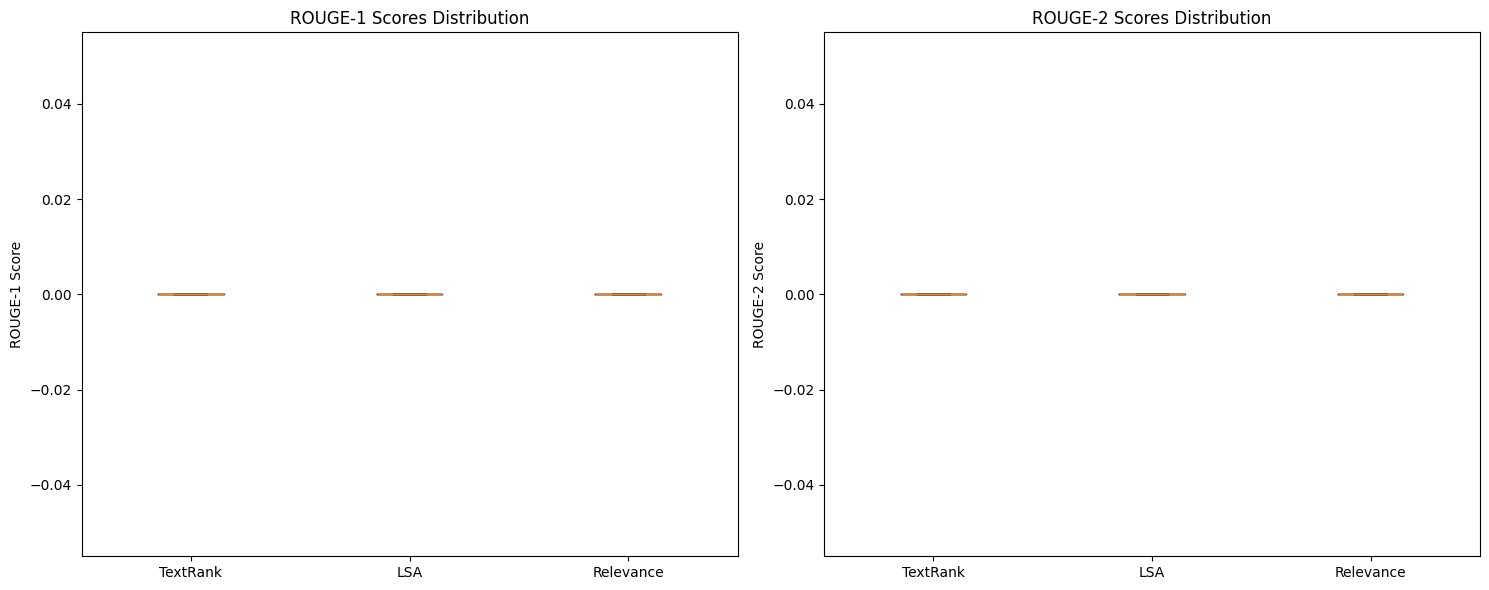

In [27]:
nltk.download('punkt')
nltk.download('stopwords')

class OpiniosisEvaluator:
    def __init__(self, base_path):
        self.base_path = base_path
        self.topics_path = os.path.join(base_path, 'topics')
        self.summaries_path = os.path.join(base_path, 'summaries-gold')
        self.rouge = Rouge()
        
        # Print debug information
        print(f"Topics path: {self.topics_path}")
        print(f"Summaries path: {self.summaries_path}")
        print("\nAvailable topics:")
        print(os.listdir(self.topics_path))
        print("\nAvailable summary directories:")
        print(os.listdir(self.summaries_path))
        
                # Debug check for a single topic
        test_topic = "interior_toyota_camry_2007"
        test_topic_file = f"{test_topic}.txt.data"
        test_topic_path = os.path.join(self.topics_path, test_topic_file)
        test_summary_dir = os.path.join(self.summaries_path, test_topic)

        print("\nDebug check for a single topic:")
        print(f"Topic file path: {test_topic_path}")
        print(f"Summary directory: {test_summary_dir}")
        print(f"Topic file exists: {os.path.exists(test_topic_path)}")
        print(f"Summary directory exists: {os.path.exists(test_summary_dir)}")
        if os.path.exists(test_summary_dir):
            print(f"Summary files: {os.listdir(test_summary_dir)}")
        
        # Initialize summarizers
        self.summarizers = {
            "TextRank": TextRankSummarizer(),
            "LSA": LsaSummarizer(),
            "Relevance": EdmundsonSummarizer()
        }
        
        # Configure Relevance (Edmundson) summarizer with domain-specific words
        self.summarizers["Relevance"].bonus_words = [
            "excellent", "good", "great", "best", "perfect", "helpful",
            "recommended", "comfortable", "amazing", "fantastic",
            "worth", "beautiful", "favorite", "lovely", "wonderful"
        ]
        self.summarizers["Relevance"].stigma_words = [
            "bad", "worst", "poor", "terrible", "awful", "horrible",
            "disappointing", "avoid", "never", "waste", "expensive"
        ]
        self.summarizers["Relevance"].null_words = [
            "the", "a", "an", "and", "or", "but", "in", "on", "at", 
            "to", "for", "with", "by", "from", "up", "about", "into"
        ]

    def load_topic_data(self, topic_file):
        """Load sentences for a given topic with different encoding attempts"""
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        for encoding in encodings:
            try:
                with open(os.path.join(self.topics_path, topic_file), 'r', encoding=encoding) as f:
                    return f.read().strip()
            except UnicodeDecodeError:
                continue
        
        # If none of the encodings work, try binary read and decode
        with open(os.path.join(self.topics_path, topic_file), 'rb') as f:
            raw_data = f.read()
            return raw_data.decode('cp1252', errors='ignore').strip()

    def load_gold_summaries(self, topic_name):
        """Load all gold summaries for a given topic"""
        gold_summaries = []
        
        # Remove all extensions (.txt.data or .txt)
        base_topic_name = topic_name.replace('.txt.data', '').replace('.txt', '')
        
        # Get the directory for this topic's summaries
        topic_dir = os.path.join(self.summaries_path, base_topic_name)
        
        if not os.path.isdir(topic_dir):
            print(f"Directory not found: {topic_dir}")
            return []
        
        # Try different encodings
        encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']
        
        # Read all gold summary files in the topic directory
        for filename in os.listdir(topic_dir):
            if not filename.endswith('.gold'):  # Look for .gold files instead of .txt
                continue
                
            file_path = os.path.join(topic_dir, filename)
            print(f"Reading gold summary: {file_path}")  # Debug print
            
            for encoding in encodings:
                try:
                    with open(file_path, 'r', encoding=encoding) as f:
                        summary = f.read().strip()
                        if summary:  # Only add non-empty summaries
                            gold_summaries.append(summary)
                            print(f"Successfully read summary of length: {len(summary)}")  # Debug print
                        break
                except UnicodeDecodeError:
                    continue
            else:
                # If none of the encodings work, try binary read
                try:
                    with open(file_path, 'rb') as f:
                        raw_data = f.read()
                        summary = raw_data.decode('cp1252', errors='ignore').strip()
                        if summary:
                            gold_summaries.append(summary)
                            print(f"Successfully read summary using binary mode, length: {len(summary)}")  # Debug print
                except Exception as e:
                    print(f"Error reading file {filename}: {e}")
        
        print(f"Total gold summaries found: {len(gold_summaries)}")  # Debug print
        return gold_summaries
    
    def debug_topic(self, topic_name):
        """Debug a specific topic's processing"""
        print(f"\nDebug check for topic: {topic_name}")
        
        # Check topic file
        topic_file = f"{topic_name}.txt.data"
        topic_path = os.path.join(self.topics_path, topic_file)
        print(f"Topic file path: {topic_path}")
        print(f"Topic file exists: {os.path.exists(topic_path)}")
        
        if os.path.exists(topic_path):
            with open(topic_path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()
                print(f"Topic text length: {len(text)}")
        
        # Check summary directory
        summary_dir = os.path.join(self.summaries_path, topic_name)
        print(f"Summary directory: {summary_dir}")
        print(f"Summary directory exists: {os.path.exists(summary_dir)}")
        
        if os.path.exists(summary_dir):
            files = os.listdir(summary_dir)
            print(f"Summary files: {files}")
            
            # Try to read one summary
            if files:
                test_file = os.path.join(summary_dir, files[0])
                try:
                    with open(test_file, 'r', encoding='utf-8', errors='ignore') as f:
                        summary = f.read()
                        print(f"First summary length: {len(summary)}")
                except Exception as e:
                    print(f"Error reading summary: {e}")

    def generate_summary(self, text, summarizer, num_sentences=3):
        """Generate summary using specified summarizer"""
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = summarizer(parser.document, num_sentences)
        return " ".join(str(sentence) for sentence in summary)

    def evaluate_topic(self, topic_text, gold_summaries, summarizer):
        """Evaluate a summarizer on a single topic against all gold summaries"""
        try:
            # Create parser for the topic text
            parser = PlaintextParser.from_string(topic_text, Tokenizer("english"))
            
            # Use average length of gold summaries to determine our summary length
            avg_gold_length = np.mean([len(nltk.sent_tokenize(summary)) for summary in gold_summaries])
            num_sentences = max(1, int(avg_gold_length))
            
            # Generate one summary
            generated_summary = " ".join(str(sent) for sent in summarizer(parser.document, num_sentences))
            
            if not generated_summary.strip():
                print("Warning: Generated empty summary")
                return 0.0, 0.0
            
            # Compare against all gold summaries and take the best score
            rouge_1_scores = []
            rouge_2_scores = []
            
            for gold_summary in gold_summaries:
                try:
                    scores = self.rouge.get_scores(generated_summary, gold_summary)[0]
                    rouge_1_scores.append(scores['rouge-1']['f'])
                    rouge_2_scores.append(scores['rouge-2']['f'])
                except Exception as e:
                    print(f"Error calculating ROUGE scores: {e}")
                    continue
            
            if not rouge_1_scores or not rouge_2_scores:
                print("Warning: No valid ROUGE scores calculated")
                return 0.0, 0.0
            
            # Return the maximum scores (best matching gold summary)
            return max(rouge_1_scores), max(rouge_2_scores)
            
        except Exception as e:
            print(f"Error in evaluate_topic: {e}")
            return 0.0, 0.0

    def evaluate_all(self):
        """Evaluate all topics with all summarizers"""
        results = {name: {'ROUGE-1': [], 'ROUGE-2': []} for name in self.summarizers.keys()}
        topics_processed = 0
        
        for topic_file in os.listdir(self.topics_path):
            if not topic_file.endswith('.data'):  # Check for .data extension
                continue
                
            topic_name = topic_file  # Keep full name for loading topic data
            base_topic_name = topic_file.replace('.txt.data', '')  # Remove extensions for printing
            print(f"\nProcessing topic: {base_topic_name}")
            
            try:
                # Load topic data
                topic_text = self.load_topic_data(topic_file)
                if not topic_text:
                    print(f"Empty topic text for: {base_topic_name}")
                    continue
                print(f"Topic text length: {len(topic_text)}")  # Debug print
                    
                # Load gold summaries
                gold_summaries = self.load_gold_summaries(topic_name)
                if not gold_summaries:
                    print(f"No gold summaries found for topic: {base_topic_name}")
                    continue
                
                print(f"Found {len(gold_summaries)} gold summaries")
                
                # Evaluate each summarizer
                for name, summarizer in self.summarizers.items():
                    print(f"Evaluating {name} summarizer...")
                    rouge_1, rouge_2 = self.evaluate_topic(topic_text, gold_summaries, summarizer)
                    print(f"ROUGE scores - R1: {rouge_1:.4f}, R2: {rouge_2:.4f}")  # Debug print
                    results[name]['ROUGE-1'].append(rouge_1)
                    results[name]['ROUGE-2'].append(rouge_2)
                
                topics_processed += 1
                
            except Exception as e:
                print(f"Error processing topic {base_topic_name}: {e}")
                continue
        
        return results, topics_processed

    def plot_results(self, results):
        """Plot ROUGE scores distribution"""
        plt.figure(figsize=(15, 6))
        
        # ROUGE-1 subplot
        plt.subplot(1, 2, 1)
        box_data = [results[name]['ROUGE-1'] for name in self.summarizers.keys()]
        plt.boxplot(box_data, labels=self.summarizers.keys())
        plt.title('ROUGE-1 Scores Distribution')
        plt.ylabel('ROUGE-1 Score')
        
        # ROUGE-2 subplot
        plt.subplot(1, 2, 2)
        box_data = [results[name]['ROUGE-2'] for name in self.summarizers.keys()]
        plt.boxplot(box_data, labels=self.summarizers.keys())
        plt.title('ROUGE-2 Scores Distribution')
        plt.ylabel('ROUGE-2 Score')
        
        plt.tight_layout()
        plt.show()

# Usage
if __name__ == "__main__":
    # Initialize evaluator
    evaluator = OpiniosisEvaluator('/home/t/Desktop/koulu/nltk/proj/NLP_2024_Project')
    
    # Run evaluation
    results, topics_processed = evaluator.evaluate_all()
    
    # Print results
    print(f"\nEvaluation completed for {topics_processed} topics")
    print("\nOverall Results:")
    for name in evaluator.summarizers.keys():
        avg_rouge1 = np.mean(results[name]['ROUGE-1'])
        avg_rouge2 = np.mean(results[name]['ROUGE-2'])
        std_rouge1 = np.std(results[name]['ROUGE-1'])
        std_rouge2 = np.std(results[name]['ROUGE-2'])
        
        print(f"\n{name} Summarizer:")
        print(f"  ROUGE-1: {avg_rouge1:.4f} (±{std_rouge1:.4f})")
        print(f"  ROUGE-2: {avg_rouge2:.4f} (±{std_rouge2:.4f})")
    
    # Plot results
    evaluator.plot_results(results)
    
